<a href="https://colab.research.google.com/github/jan-de-trop/Racial-Bias/blob/main/Racial_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Racial Bias in Machine Learning Systems <h1>

After pressure from several news agencies and a public investigation by ProPublica, Northpointe, an American tech-company that works with law establishment across several states in the US to predict future crimes based on past records of criminals, released this dataset with a slice of the factors usually considered in order to assign a score to criminals.
It has been speculated that their software- COMPAS- is biased against the african-american criminals, who end up with high-risk tags, despite minor criminal record, whereas Caucasians regularly received low scores despite more significant criminal charges. We try to see how the bias affects a machine learning system.

### Importing the libraries

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from prettytable import PrettyTable
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set()


### Loading the dataset and preprocessing

In [13]:
# Get the data
df = pd.read_csv('compas.csv')

#Splitting the races
aa_df = df[df['race'] == 'African-American']
cc_df = df[df['race'] == 'Caucasian']

df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,50,M,arrest case no charge,Caucasian,Medium,0,30,0,0,0,6,1,4,0,0,1,0,0,0,0,0,0,4
1,28,M,Susp Drivers Lic 1st Offense,African-American,Medium,1,0,0,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0
2,24,F,Aggravated Assault W/dead Weap,Other,Low,1,1,0,0,0,4,1,5,1,0,0,0,0,0,0,1,0,5
3,25,F,Burglary Unoccupied Dwelling,Hispanic,Medium,0,14,0,1,2,6,0,1,0,0,1,0,1,1,0,0,1,1
4,34,F,Possession of Cannabis,African-American,Medium,1,7,0,0,0,6,1,0,0,0,1,0,0,0,1,0,0,0


We process the categorical predictors before splitting to make sure that we don't lose some categories due to the split. If this happens we might not have any encoding for a particular value the categorical variable takes.

In [34]:
# One hot encode
one_hot_df = pd.get_dummies(df['race'], prefix='race', drop_first = True)

# columns of interest
cols = df.select_dtypes(include=np.number).columns.tolist()
df_race = pd.concat([df[cols], one_hot_df], axis=1)

## Splitting the data

data_train, data_val = train_test_split(df_race, train_size = 0.8, stratify = df['race'], random_state = 109)
y_train, X_train = data_train.two_year_recid, data_train.drop(['two_year_recid'], axis=1)
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid'], axis=1)


(4443, 23)

### Visualisation

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


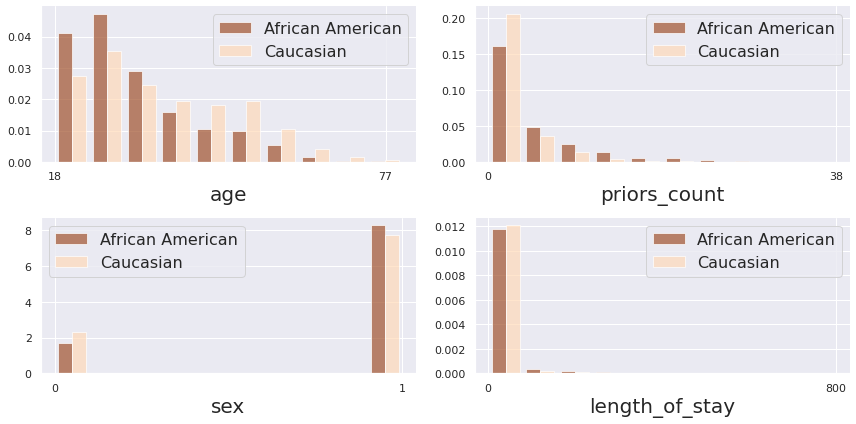

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,6))
ax = ax.ravel()
colors = ['sienna','peachpuff']

for i, col in enumerate(['age', 'priors_count','sex','length_of_stay']):
    aa = np.array(aa_df[col]).flatten() 
    cc = np.array(cc_df[col]).flatten()
    ax[i].hist([aa,cc], label = ['African American','Caucasian'], alpha = 0.7, density = True,bins = 10,color=colors)
    ax[i].set_xlabel(f'{col}',fontsize = 20)
    ax[i].set_xticks([aa.min(),aa.max()])
    ax[i].legend(fontsize = 16)
sns.despine();
plt.tight_layout()

### Baseline Model - Logistic Regression 

In [16]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)

print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)}')

 Training set accuracy = 0.7 
 validation set accuracy = 0.68


In [17]:
# Separating the races 
X_val = X_val.reset_index(drop='True')

aa_ind = np.array(X_val[(X_val['race_Asian'] == 0) & (X_val['race_Caucasian'] == 0) 
                & (X_val['race_Other'] == 0) & (X_val['race_Native American'] == 0)].index.tolist())

cc_ind = np.array(X_val[X_val['race_Caucasian'] == 1].index.tolist())

In [18]:
aa_fplist = []
cc_fplist = []
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)

print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x,"\n\n")

print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')

print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

African Americans
[[221 104]
 [107 231]]
Caucasians
[[185  59]
 [ 69  65]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |        32.0       |   24.18    |
| False -ves % |       31.66       |   51.49    |
+--------------+-------------------+------------+ 


African Americans 1.3x more likely to be falsely flagged compared to Caucasians
Caucasians 1.6x more likely to be mislabeled as low risk compared to African Americans


The FPR ratio value indicates that African-American criminals (or those with a criminal history in past two years) are 62% more likely to be convicted falsely than those of Caucasian origin. Also, Caucasian criminals are 51% less likely to serve jail time or be found guilty despite committing a crime. Thus, the model shows a racial bias against criminals of African-American origin.

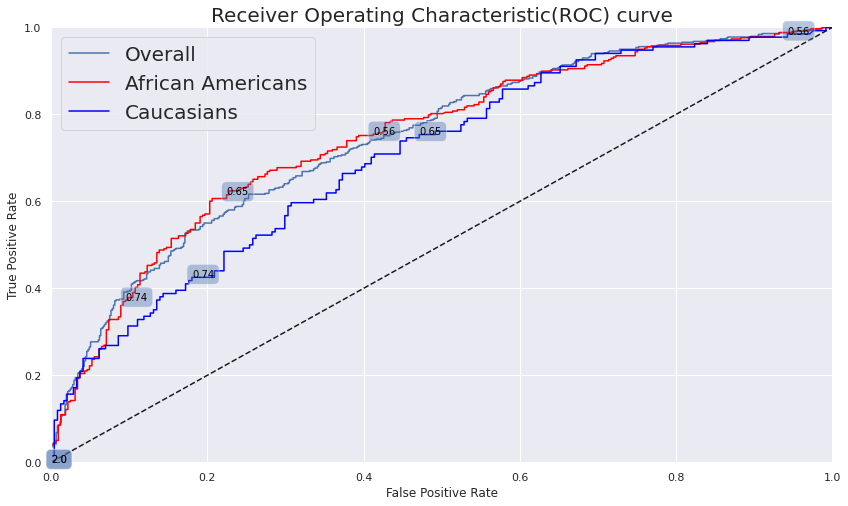

In [19]:
# Probabilities
yprobs = logreg.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, yprobs)


# aa_ind african americans
# cc_ind caucasians


aa_fpr, aa_tpr, aa_thresholds = roc_curve(y_val.values[aa_ind],yprobs[aa_ind])
cc_fpr, cc_tpr, cc_thresholds = roc_curve(y_val.values[cc_ind],yprobs[cc_ind])

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(fpr,tpr,color = 'b', label = 'Overall')
ax.plot(aa_fpr, aa_tpr, color = 'red',label = 'African Americans')
ax.plot(cc_fpr, cc_tpr, color = 'blue',label = 'Caucasians')
ax.plot([0,1],[0,1],'k--')

label_kwargs = {}
label_kwargs['bbox'] = dict(boxstyle = 'round, pad = 0.5', alpha =0.4)


n_fpr = fpr.shape[0]

for k in range(0,200,50):
    threshold = str(np.round(thresholds[k],2))
    ax.annotate(threshold, (aa_fpr[k],aa_tpr[k]), color = 'black', **label_kwargs)
    ax.annotate(threshold, (cc_fpr[k],cc_tpr[k]), color = 'black', **label_kwargs)
   
    
# Aesthetics

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic(ROC) curve',fontsize = 20)
ax.legend(loc='best',fontsize=20)
sns.despine()

### Race-less model

It can be thought that the predictor which is causing the bias - race - can be eliminated while modelling to avoid bias in the model. We will try to see how that might not be even remotely true in our case.

In [37]:
# Not to include 'race' as a predictor 

data_train, data_val = train_test_split(df[cols], train_size = 0.8, stratify = df['race'], random_state=109)
y_train, X_train = data_train.two_year_recid, data_train.drop(['two_year_recid'], axis=1)
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid'], axis=1)

In [38]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)
print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)} \n\n')
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)
print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x,"\n\n")
print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')
print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

 Training set accuracy = 0.7 
 validation set accuracy = 0.68 


African Americans
[[221 104]
 [105 233]]
Caucasians
[[190  54]
 [ 71  63]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |        32.0       |   22.13    |
| False -ves % |       31.07       |   52.99    |
+--------------+-------------------+------------+ 


African Americans 1.4x more likely to be falsely flagged compared to Caucasians
Caucasians 1.7x more likely to be mislabeled as low risk compared to African Americans


We observe more or less the same results whem race is not included as a predictor. This is due to the proxy variables that are indirectly affected by race. This gives almost the same results as our baseline model. The bias still occurs. The disparity is an inherent property of the dataset itself and is not due to using race as a predictor.

### Modelling with SMOTE

With a view to reduce the bias in the model prediction, we try to find what's causing the bias in the first place. Historical data points toward a greater number of African-American convicts than Caucasian ones . We try to counter this by oversmpling with SMOTE. 

A new metric BCA - Bias Corrected Accuracy - defined as the difference between the accuracy and the absolute difference between the FPR scores of the two classes that includes both accuracy and the bias is introduced. We aim to maximixze the BCA by choosing a threshold where the bias is minimum (refer to the ROC curve).

In [44]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

data_train, data_val = train_test_split(df[cols + ['race']], train_size = 0.8, stratify = df['race'], random_state=109)
os = SMOTE(random_state= 109)
os_data_X, os_data_y  = os.fit_sample(data_train[cols],data_train['race'])
print(os_data_y)



['African-American' 'Caucasian' 'Asian' ... 'Other' 'Other' 'Other']


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [29]:
df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,50,M,arrest case no charge,Caucasian,Medium,0,30,0,0,0,6,1,4,0,0,1,0,0,0,0,0,0,4
1,28,M,Susp Drivers Lic 1st Offense,African-American,Medium,1,0,0,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0
2,24,F,Aggravated Assault W/dead Weap,Other,Low,1,1,0,0,0,4,1,5,1,0,0,0,0,0,0,1,0,5
3,25,F,Burglary Unoccupied Dwelling,Hispanic,Medium,0,14,0,1,2,6,0,1,0,0,1,0,1,1,0,0,1,1
4,34,F,Possession of Cannabis,African-American,Medium,1,7,0,0,0,6,1,0,0,0,1,0,0,0,1,0,0,0


In [45]:
data_X = pd.DataFrame({'age':os_data_X[:,0],'sex':os_data_X[:,1],'priors_count':os_data_X[:,2],'juv_fel_count':os_data_X[:,3],'juv_misd_count':os_data_X[:,4],'juv_other_count':os_data_X[:,5],'decile_score':os_data_X[:,6],'two_year_recid':os_data_X[:,7],'length_of_stay':os_data_X[:,8],'priors_1':os_data_X[:,9],'priors_234':os_data_X[:,10],'priors_5plus':os_data_X[:,11],'juv_fel_1plus':os_data_X[:,12],'juv_misd_1plus':os_data_X[:,13],'juv_other_1plus':os_data_X[:,14],'charge_any_drug':os_data_X[:,15],'charge_any_violence_aggression':os_data_X[:,16],'charge_any_theft':os_data_X[:,17],'length_of_stay_thresh':os_data_X[:,18]})

In [47]:
X_train, y_train = data_X.drop(['two_year_recid'],axis=1), data_X.two_year_recid
y_val, X_val = data_val.two_year_recid, data_val.drop(['two_year_recid', 'race'], axis=1)

In [48]:
logreg = LogisticRegression(C=100000, solver = 'lbfgs', max_iter = 10000)
logreg.fit(X_train, y_train)

ypred_train = logreg.predict(X_train)
ypred_val = logreg.predict(X_val)
print(f' Training set accuracy = {round(accuracy_score(y_train, ypred_train),2)} \n validation set accuracy = {round(accuracy_score(y_val, ypred_val),2)} \n\n')
print('African Americans')
aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind])  
print(aa_cm)
print('Caucasians')
cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
print(cc_cm)

fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
aa_fplist.append(fp_aa)
cc_fplist.append(fp_cc)
x = PrettyTable()
x.field_names = ['Race','African Americans','Caucasians']
x.add_row(['False +ves %', fp_aa, fp_cc])
x.add_row(['False -ves %', fn_aa, fn_cc])
print(x,"\n\n")
print(f'African Americans {fp_aa/fp_cc:0.1f}x more likely to be falsely flagged compared to Caucasians')
print(f'Caucasians {fn_cc/fn_aa:0.1f}x more likely to be mislabeled as low risk compared to African Americans')

 Training set accuracy = 0.81 
 validation set accuracy = 0.67 


African Americans
[[257  68]
 [158 180]]
Caucasians
[[212  32]
 [ 90  44]]
+--------------+-------------------+------------+
|     Race     | African Americans | Caucasians |
+--------------+-------------------+------------+
| False +ves % |       20.92       |   13.11    |
| False -ves % |       46.75       |   67.16    |
+--------------+-------------------+------------+ 


African Americans 1.6x more likely to be falsely flagged compared to Caucasians
Caucasians 1.4x more likely to be mislabeled as low risk compared to African Americans


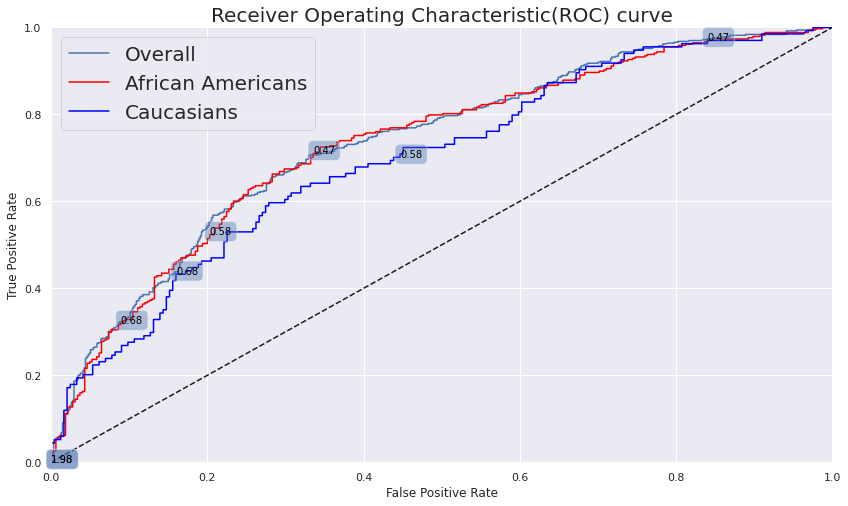

In [49]:
# Probabilities
yprobs = logreg.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, yprobs)


# aa_ind african americans
# cc_ind caucasians


aa_fpr, aa_tpr, aa_thresholds = roc_curve(y_val.values[aa_ind],yprobs[aa_ind])
cc_fpr, cc_tpr, cc_thresholds = roc_curve(y_val.values[cc_ind],yprobs[cc_ind])

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(fpr,tpr,color = 'b', label = 'Overall')
ax.plot(aa_fpr, aa_tpr, color = 'red',label = 'African Americans')
ax.plot(cc_fpr, cc_tpr, color = 'blue',label = 'Caucasians')


ax.plot([0,1],[0,1],'k--')

label_kwargs = {}
label_kwargs['bbox'] = dict(boxstyle = 'round, pad = 0.5', alpha =0.4)


n_fpr = fpr.shape[0]

for k in range(0,200,50):
    threshold = str(np.round(thresholds[k],2))
    ax.annotate(threshold, (aa_fpr[k],aa_tpr[k]), color = 'black', **label_kwargs)
    ax.annotate(threshold, (cc_fpr[k],cc_tpr[k]), color = 'black', **label_kwargs)
   
    
# Aesthetics

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic(ROC) curve',fontsize = 20)
ax.legend(loc='best',fontsize=20)
sns.despine()

In [50]:
threshdict = {}
thresholds = np.linspace(0,1,101)
for i in thresholds:
    ypred_val = [1 if prob >= i else 0 for prob in yprobs]
    aa_cm = metrics.confusion_matrix(np.array(y_val)[aa_ind], np.array(ypred_val)[aa_ind]) 
    cc_cm = metrics.confusion_matrix(np.array(y_val)[cc_ind], np.array(ypred_val)[cc_ind])
    fp_aa, fn_aa, fp_cc, fn_cc = round(aa_cm[0,1]/aa_cm[0].sum()*100,2),round(aa_cm[1,0]/aa_cm[1].sum()*100,2),round(cc_cm[0,1]/cc_cm[0].sum()*100,2),round(cc_cm[1,0]/cc_cm[1].sum()*100,2)
    round(accuracy_score(y_val, ypred_val),2)
    threshdict[i] = [fp_aa,fp_cc,100*round(accuracy_score(y_val, ypred_val),2)]

In [51]:
thresh_data = list(threshdict.values())
thresh_fp_aa, thresh_fp_cc, thresh_acc = [i[0] for i in thresh_data],[i[1] for i in thresh_data],[i[2] for i in thresh_data]

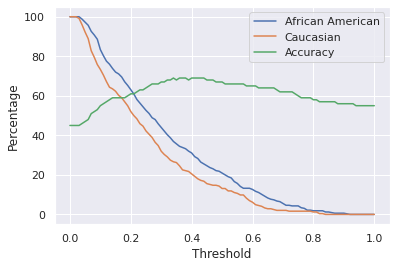

In [52]:
fig,ax = plt.subplots()
ax.plot(list(threshdict.keys()),thresh_fp_aa,label = 'African American')
ax.plot(list(threshdict.keys()),thresh_fp_cc,label = 'Caucasian')
ax.plot(list(threshdict.keys()),thresh_acc,label = 'Accuracy')
ax.set_xlabel("Threshold")
ax.set_ylabel("Percentage")
ax.legend();

In [53]:
def bca(acc,x,y):  
    x=np.array(x)
    y=np.array(y)
    acc=np.array(acc)
    return acc - np.absolute(x-y)

In [54]:
bca_list=bca(thresh_acc,thresh_fp_aa,thresh_fp_cc)

In [55]:
bca_ind=np.argmax(bca_list)
best_thresh=thresholds[bca_ind]
print("Best threshold is", best_thresh," with a BCA of", bca_list[bca_ind])
print("The corresponding accuracy is ", threshdict[best_thresh][2], "and the FPR for African Americans and Caucasians are", threshdict[best_thresh][0],"and",threshdict[best_thresh][1]," respectively.")

Best threshold is 0.5700000000000001  with a BCA of 62.61
The corresponding accuracy is  66.0 and the FPR for African Americans and Caucasians are 13.23 and 9.84  respectively.


In [56]:
bca_ind=np.argmax(bca_list)
best_thresh=thresholds[bca_ind]
print("Best threshold is", best_thresh," with a BCA of", bca_list[bca_ind])
print("The corresponding accuracy is ", threshdict[best_thresh][2], "and the FPR for African Americans and Caucasians are", threshdict[best_thresh][0],"and",threshdict[best_thresh][1]," respectively.")

Best threshold is 0.5700000000000001  with a BCA of 62.61
The corresponding accuracy is  66.0 and the FPR for African Americans and Caucasians are 13.23 and 9.84  respectively.


### Conclusion

Prediction, when made by a model, is in reference to past data and trends. If a dataset is tainted with bias, human or otherwise, the model cannot be trusted, or expected, to be free of bias. Correlation between a variable such as race and other predictors might be a reason why a bias is still observed. Dropping features left and right with slight correlation to biased predictors could result in loss of accuracy as well as relevant information and these predictors would only yeild similar results regardless of whether the model uses race as a predictor explicitly or not.

As a data scientist, it is of utmost importance to realise that the data we use to train our models might not always be suitable and the models so trained cannot be trusted to give results even close to reality.